In [1]:
import os
import optparse
import yaml
import importlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [236]:
# usage = 'usage: %prog [options]'
# parser = optparse.OptionParser(usage)

# parser.add_option('-o', '--outDir',
#                     dest='outputPath',
#                     help='output directory',
#                     type='string')

# (opt, args) = parser.parse_args()

In [402]:
### Parameters of the training ###

#split = "even" 
split = "odd" 
# split = even | odd -> on what split to train the model (will be in the name)
# -> you need one "odd" and one "even" models to be put inside bamboo

suffix = 'test1'
# Suffix that will be added to the saved model (so multiple DNNs can be trained)

quantile = 1.0 # We will repeat the part of the weights rightmost tail
# Eg : 0.95, means we take the 5% events on the right tail of training weight and repeat them
# 1.0 means no correction (to be used if you want to disable it)

tags = ['HH','background']

# DNN hyperparameters #
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 256,
    'n_layers'              : 3,
    'n_neurons'             : 64,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'softmax',
    'l2'                    : 1e-6,
    'dropout'               : 0.,
    'batch_norm'            : True,
}
# Input variables
input_vars=[
    "weight",
    "ak4bjet1_pt",
    "ak4bjet1_eta",
    "ak4bjet1_phi",
    "leadingLepton_pt",
    "leadingLepton_eta",
    "leadingLepton_phi",
    "subleadingLepton_pt",
    "subleadingLepton_eta",
    "subleadingLepton_phi"
    ]

print(f'Using {len(input_vars)} input variables')

Using 10 input variables


In [403]:
outputPath = '../output/mvaSkim-try2-full'
yamlFile = os.path.join(outputPath,'plots.yml')
skimFile = os.path.join(outputPath,'results/DL_resolved.parquet')
# yamlFile = os.path.join(opt.outputPath,'plots.yml')
# skimFile = os.path.join(opt.outputPath,'results/DL_resolved.parquet')

print(f'Using skim file {skimFile}')
print(f'Using yaml file {yamlFile}')

Using skim file ../output/mvaSkim-try2-full/results/DL_resolved.parquet
Using yaml file ../output/mvaSkim-try2-full/plots.yml


In [404]:
# Load dataframe from parquet file
df = pd.read_parquet(skimFile)
df.head()

,ak4bjet1_eta,ak4bjet1_phi,ak4bjet1_pt,leadingLepton_eta,leadingLepton_phi,leadingLepton_pt,subleadingLepton_eta,subleadingLepton_phi,subleadingLepton_pt,weight,process
0,-1.425537,-1.323486,126.18750,-0.161804,0.887695,28.389597,-0.295227,-1.368896,19.328093,1.0,data
1,1.196289,-0.498291,48.59375,0.316284,-2.869141,109.997726,-0.364014,-0.565308,38.170570,1.0,data
2,1.066406,-1.631836,59.71875,-0.137390,-2.448730,66.637535,0.118851,-1.097900,41.266010,1.0,data
3,-1.093506,1.346436,96.00000,0.023682,-0.669556,51.262684,0.521362,2.923340,50.410046,1.0,data
4,1.292480,1.234619,50.28125,0.571655,2.450684,202.467529,1.092041,-0.964966,44.808109,1.0,data


In [405]:
# Add tag column #
df['tag'] = 'background'
df.loc[df.process.str.contains('HH'),['tag']] = 'HH'
df["tag"].unique()

array(['background', 'HH'], dtype=object)

In [406]:
assert len(set(tags).intersection(set(pd.unique(df['tag'])))) == len(tags) # Just cross check to avoid mistakes
df.head()

,ak4bjet1_eta,ak4bjet1_phi,ak4bjet1_pt,leadingLepton_eta,leadingLepton_phi,leadingLepton_pt,subleadingLepton_eta,subleadingLepton_phi,subleadingLepton_pt,weight,process,tag
0,-1.425537,-1.323486,126.18750,-0.161804,0.887695,28.389597,-0.295227,-1.368896,19.328093,1.0,data,background
1,1.196289,-0.498291,48.59375,0.316284,-2.869141,109.997726,-0.364014,-0.565308,38.170570,1.0,data,background
2,1.066406,-1.631836,59.71875,-0.137390,-2.448730,66.637535,0.118851,-1.097900,41.266010,1.0,data,background
3,-1.093506,1.346436,96.00000,0.023682,-0.669556,51.262684,0.521362,2.923340,50.410046,1.0,data,background
4,1.292480,1.234619,50.28125,0.571655,2.450684,202.467529,1.092041,-0.964966,44.808109,1.0,data,background


In [407]:
# One-hot encoding is a way to convert a column to a format that is easier for machine learning applications
# Here I transform the tag (bkg or signal) column to binary and add it as new columns

one_hot = pd.get_dummies(df['tag'], dtype=float)
df = pd.concat((df,one_hot),axis=1)

df.head()

,ak4bjet1_eta,ak4bjet1_phi,ak4bjet1_pt,leadingLepton_eta,leadingLepton_phi,leadingLepton_pt,subleadingLepton_eta,subleadingLepton_phi,subleadingLepton_pt,weight,process,tag,HH,background
0,-1.425537,-1.323486,126.18750,-0.161804,0.887695,28.389597,-0.295227,-1.368896,19.328093,1.0,data,background,0.0,1.0
1,1.196289,-0.498291,48.59375,0.316284,-2.869141,109.997726,-0.364014,-0.565308,38.170570,1.0,data,background,0.0,1.0
2,1.066406,-1.631836,59.71875,-0.137390,-2.448730,66.637535,0.118851,-1.097900,41.266010,1.0,data,background,0.0,1.0
3,-1.093506,1.346436,96.00000,0.023682,-0.669556,51.262684,0.521362,2.923340,50.410046,1.0,data,background,0.0,1.0
4,1.292480,1.234619,50.28125,0.571655,2.450684,202.467529,1.092041,-0.964966,44.808109,1.0,data,background,0.0,1.0


In [408]:
df = df[df.weight > 0] # remove events with negative weight

# copy the weight column as event weight to calculate it later
df['event_weight'] = df['weight'].copy()

if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

    # copy the weight column as training weight
if 'training_weight' in df.columns:
    del df['training_weight']
    
df['training_weight'] = df['event_weight'].copy()

# and normalize the training weight
for tag in df.tag.unique():
    # training weight *= Nevents / sum of event weight
    df.loc[df['tag']==tag,'training_weight'] *= df.shape[0] / df[df['tag']==tag]['event_weight'].sum()

df = df[(df['weight']>0) & (df['training_weight'] < 200)]

df

,ak4bjet1_eta,ak4bjet1_phi,ak4bjet1_pt,leadingLepton_eta,leadingLepton_phi,leadingLepton_pt,subleadingLepton_eta,subleadingLepton_phi,subleadingLepton_pt,weight,process,tag,HH,background,event_weight,training_weight
0,-1.425537,-1.323486,126.187500,-0.161804,0.887695,28.389597,-0.295227,-1.368896,19.328093,1.000000,data,background,0.0,1.0,1.000000,32.252710
1,1.196289,-0.498291,48.593750,0.316284,-2.869141,109.997726,-0.364014,-0.565308,38.170570,1.000000,data,background,0.0,1.0,1.000000,32.252710
2,1.066406,-1.631836,59.718750,-0.137390,-2.448730,66.637535,0.118851,-1.097900,41.266010,1.000000,data,background,0.0,1.0,1.000000,32.252710
3,-1.093506,1.346436,96.000000,0.023682,-0.669556,51.262684,0.521362,2.923340,50.410046,1.000000,data,background,0.0,1.0,1.000000,32.252710
4,1.292480,1.234619,50.281250,0.571655,2.450684,202.467529,1.092041,-0.964966,44.808109,1.000000,data,background,0.0,1.0,1.000000,32.252710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,-1.020264,3.117188,73.687500,0.356567,0.664185,68.745995,0.180359,-1.651855,20.385309,0.048003,TW,background,0.0,1.0,0.048003,1.548232
23,1.184570,-2.783203,117.500000,1.810303,2.923828,74.987442,-1.382324,-0.100479,66.208122,0.048003,TW,background,0.0,1.0,0.048003,1.548232
24,0.140533,-2.455566,65.812500,2.162109,-0.287842,37.344887,2.193359,0.247986,22.928656,0.048003,TW,background,0.0,1.0,0.048003,1.548232
25,1.588623,0.117950,31.234375,-0.940918,-1.534912,70.015762,-2.367676,-2.570801,15.644615,0.048003,TW,background,0.0,1.0,0.048003,1.548232


In [409]:
import utils
importlib.reload(utils) # Reload in case file has changed

<module 'utils' from '/Users/guzela/Downloads/python/utils.py'>

In [410]:
print ('Using event weight')
utils.checkBatches(df, label_column='tag', weight_column='event_weight', batch_size=parameters['batch_size'])
print ('Using training weight')
utils.checkBatches(df, label_column='tag', weight_column='training_weight', batch_size=parameters['batch_size'])

Using event weight
On average, per batch the total weight is
	... background          :     7.864079145 [252.35 events]
	... HH                  :     0.000737797 [3.65 events]
Using training weight
On average, per batch the total weight is
	... background          :   247.242168425 [252.295 events]
	... HH                  :   260.812471887 [3.705 events]


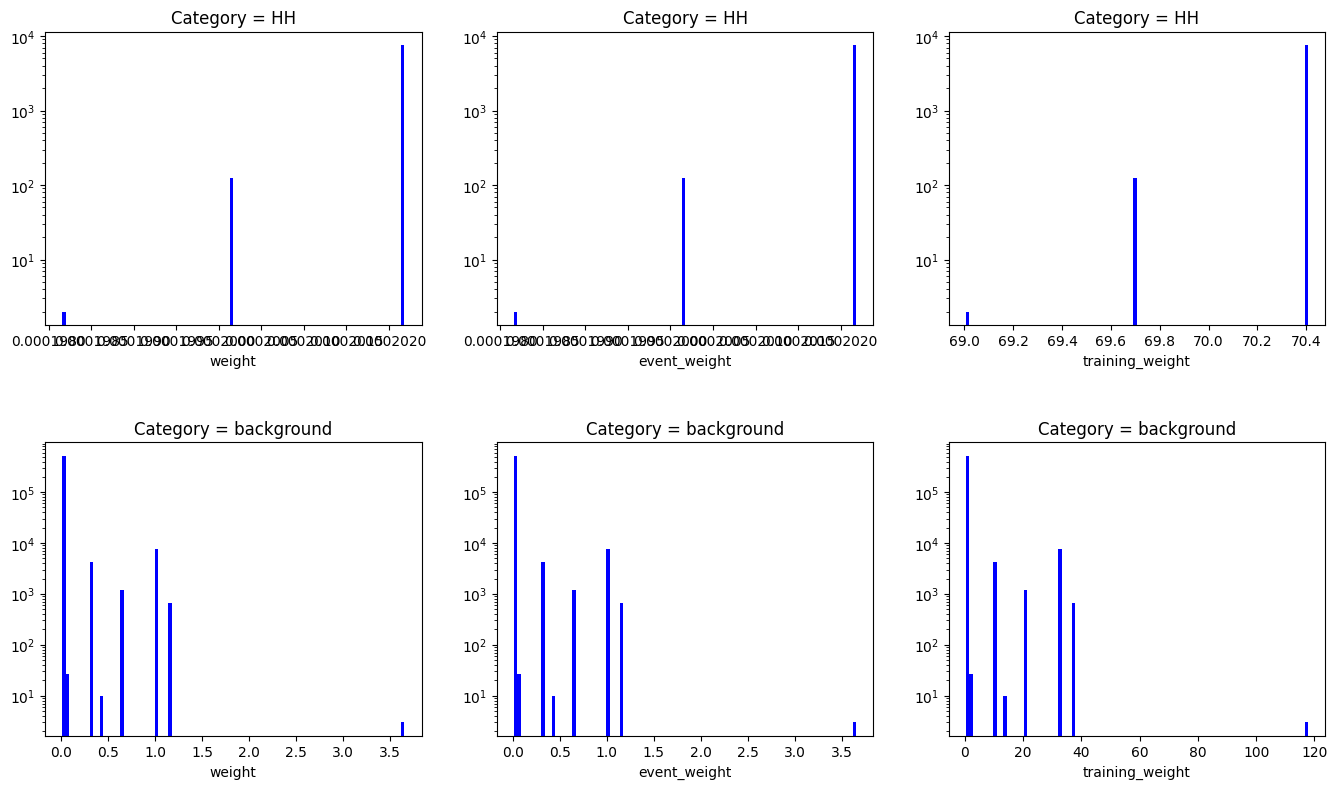

In [411]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=len(tags),ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.4)
for irow,tag in enumerate(tags):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['tag']==tag][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Category = {tag}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
fig.savefig("event_weights_A.pdf", dpi = 300)

In [412]:
# Determine splitting variable #
split_var = np.abs(df['leadingLepton_phi'].copy())
split_var *= 1e4
split_var -= np.floor(split_var)
split_var = (split_var*1e1).astype(int)
split_var = split_var %2 == 0
print (f'Even set has {df[split_var].shape[0]:10d} events [{df[split_var].shape[0]/df.shape[0]*100:5.2f}%]')
print (f'Odd  set has {df[~split_var].shape[0]:10d} events [{df[~split_var].shape[0]/df.shape[0]*100:5.2f}%]')

Even set has     272434 events [50.02%]
Odd  set has     272214 events [49.98%]


In [413]:
# Sets splitting #
print (f'Using split type {split}')
if split == 'even':
    train_df = df[~split_var] # Trained on odd
    test_df  = df[split_var]  # Evaluated on even 
elif split == 'odd':
    train_df = df[split_var]  # Trained on even
    test_df  = df[~split_var] # Evaluated on odd 
else:
    raise RuntimeError(f'Split needs to be either odd or even, is {split}')

Using split type odd


In [414]:
# Randomize for training
train_df = train_df.sample(frac=1)

In [415]:
# Quantile corrections #
# When an event has a large weight, it can imbalance a lot the training, still the weight might have a meaning
# Idea : instead of 1 event with wi>>1, we use N copies of the event with wf = wi/N
# From the point of view of the physics it does not matter, the total event weight sum of each process is the same
# From the point of view of the DNN, we have split a tough nut to crack into several smaller ones

quantile_lim = train_df['training_weight'].quantile(1)
print (f'{(1-quantile)*100:5.2f}% right quantile is when weight is at {quantile_lim}')
print ('  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability')

 0.00% right quantile is when weight is at 70.4070718532353
  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability


In [416]:
# Select the events #
idx_to_repeat = train_df['training_weight'] >= quantile_lim
events_excess = train_df[idx_to_repeat].copy()
saved_columns = train_df[['training_weight','process']].copy()
# Compute multiplicative factor #
factor = (events_excess['training_weight']/quantile_lim).values.astype(np.int32)
# Correct the weights of events already in df #
train_df.loc[idx_to_repeat,'training_weight'] /= factor
# Add N-1 copies #
arr_to_repeat = train_df[idx_to_repeat].values
repetition = np.repeat(np.arange(arr_to_repeat.shape[0]), factor-1)
df_repeated = pd.DataFrame(np.take(arr_to_repeat,repetition,axis=0),columns=train_df.columns)
df_repeated = df_repeated.astype(train_df.dtypes.to_dict()) # otherwise dtypes are object
train_df = pd.concat((train_df,df_repeated),axis=0,ignore_index=True).sample(frac=1).reset_index() # Add and randomize
# Printout #
print ('Changes per process in training set')
for process in pd.unique(train_df['process']):
    N_before = saved_columns[saved_columns['process']==process].shape[0]
    N_after  = train_df[train_df['process']==process].shape[0]
    if N_before != N_after:
        print (f"{process:20s}")
        print (f"... {N_before:6d} events [sum weight = {saved_columns[saved_columns['process']==process]['training_weight'].sum():14.6f}]",end=' -> ')
        print (f"{N_after:6d} events [sum weight = {train_df[train_df['process']==process]['training_weight'].sum():14.6f}]")
print (f"Total entries : {saved_columns.shape[0]:14d} -> {train_df.shape[0]:14d}")
print (f"Total event sum : {saved_columns['training_weight'].sum():14.6f} -> {train_df['training_weight'].sum():14.6f}")

# Validation split #
train_df,val_df  = train_test_split(train_df,test_size=0.3)

# Printout #
print ('\nFinal sets')
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Changes per process in training set
Total entries :         272434 ->         272434
Total event sum :  544514.236228 ->  544514.236228

Final sets
Training set   = 190703
Validation set = 81731
Testing set    = 272214
Total set      = 544648


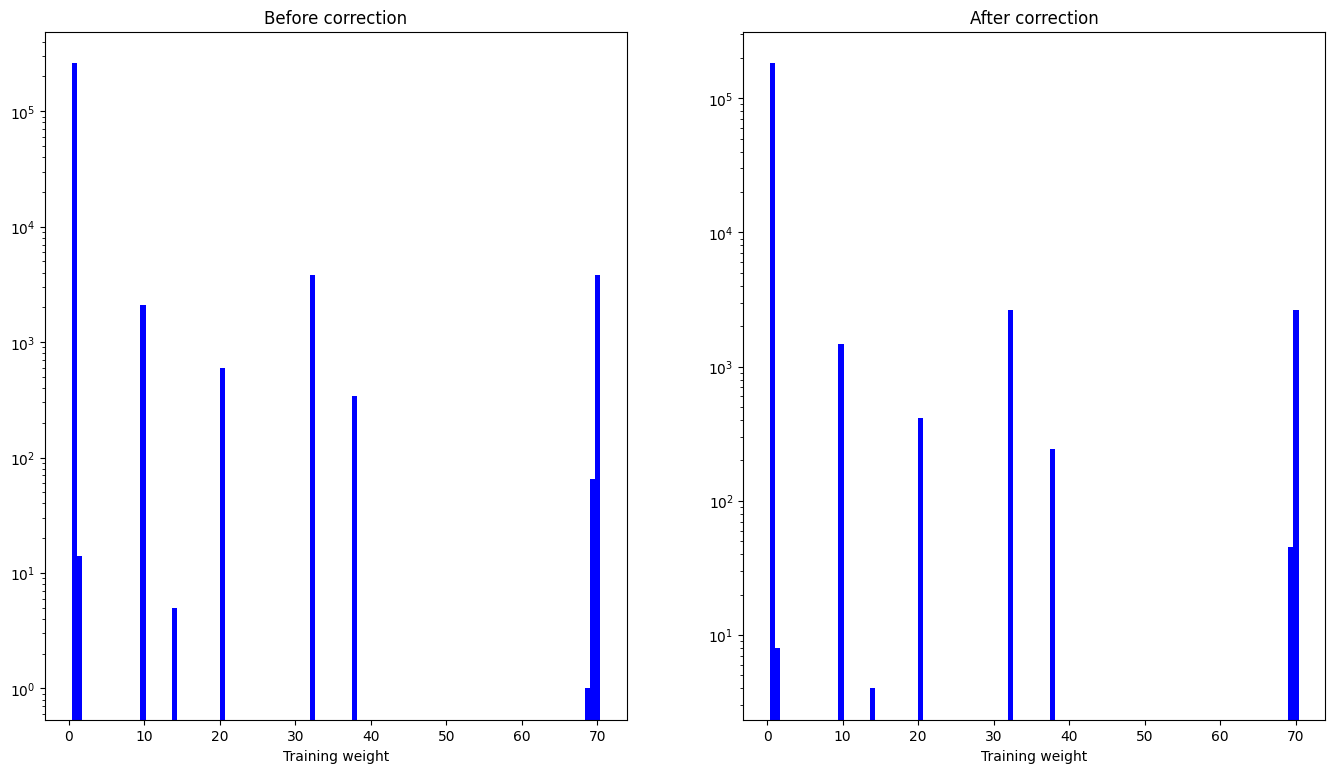

In [417]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)

if split == 'even':
    axs[0].hist(df[~split_var]['training_weight'],bins=100,color='b')
elif split == 'odd':
    axs[0].hist(df[split_var]['training_weight'],bins=100,color='b')
axs[0].set_title("Before correction")
axs[0].set_xlabel("Training weight")
axs[0].set_yscale('log')
axs[1].hist(train_df['training_weight'],bins=100,color='b')
axs[1].set_title("After correction")
axs[1].set_xlabel("Training weight")
axs[1].set_yscale('log')
fig.savefig("event_weights_C.pdf", dpi = 300)

In [418]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")
# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                        variance = train_df[input_vars].var(axis=0),
                                        name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                    activation           = parameters['hidden_activation'], 
                    activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                    name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 2, 
                    activation           = parameters['output_activation'],
                    activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                    name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

In [419]:
model_preprocess = keras.Model(inputs=inputs, outputs=normalizer)
out_test = model_preprocess.predict(train_df[input_vars],batch_size=5000)
print ('Input (after normalization) mean (should be close to 0)')
print (out_test.mean(axis=0))
print ('Input (after normalization) variance (should be close to 1)')
print (out_test.var(axis=0))

model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.legacy.Adam(learning_rate=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()],
    weighted_metrics=[]
)

model.summary()

39/39 [==============================] - 0s 295us/step
Input (after normalization) mean (should be close to 0)
[ 4.9803480e-06 -7.3190975e-08 -1.2268456e-09 -3.5574692e-09
 -5.3763511e-08 -1.2000286e-08 -1.0226083e-08  6.0846730e-08
  1.0623024e-08  5.3276086e-09]
Input (after normalization) variance (should be close to 1)
[0.998694   0.99994934 0.9999602  0.9999641  0.9999508  0.9999375
 0.99995667 0.9999552  0.999963   0.9999661 ]
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 10)]              0         
                                                                 
 Normalization (Normalizati  (None, 10)                0         
 on)                                                             
                                                                 
 dense_0 (Dense)             (None, 64)                704       
                  

In [420]:

# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                            min_delta = 0.001, 
                            patience = 20,
                            verbose=1,
                            mode='min',
                            restore_best_weights=True)
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.1,
                                min_delta = 0.001, 
                                patience = 8,
                                min_lr = 1e-8,
                                verbose=2,
                                mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [421]:
history = model.fit(
    train_df[input_vars],
    train_df[tags],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df[tags],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)

Epoch 1/200
745/745 - 1s - loss: 0.6349 - binary_accuracy: 0.4776 - auc_4: 0.5157 - precision_4: 0.4776 - recall_4: 0.4776 - val_loss: 0.4489 - val_binary_accuracy: 0.6379 - val_auc_4: 0.7284 - val_precision_4: 0.6379 - val_recall_4: 0.6379 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 2/200
745/745 - 1s - loss: 0.2252 - binary_accuracy: 0.8244 - auc_4: 0.9142 - precision_4: 0.8244 - recall_4: 0.8244 - val_loss: 0.0352 - val_binary_accuracy: 0.9902 - val_auc_4: 0.9991 - val_precision_4: 0.9902 - val_recall_4: 0.9902 - lr: 0.0010 - 782ms/epoch - 1ms/step
Epoch 3/200
745/745 - 1s - loss: 0.0084 - binary_accuracy: 0.9983 - auc_4: 0.9998 - precision_4: 0.9983 - recall_4: 0.9983 - val_loss: 0.0023 - val_binary_accuracy: 0.9999 - val_auc_4: 1.0000 - val_precision_4: 0.9999 - val_recall_4: 0.9999 - lr: 0.0010 - 783ms/epoch - 1ms/step
Epoch 4/200
745/745 - 1s - loss: 0.0019 - binary_accuracy: 0.9999 - auc_4: 1.0000 - precision_4: 0.9999 - recall_4: 0.9999 - val_loss: 0.0011 - val_binary_accuracy: 0

Epoch 29/200
745/745 - 1s - loss: 7.7769e-05 - binary_accuracy: 1.0000 - auc_4: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 8.0237e-05 - val_binary_accuracy: 1.0000 - val_auc_4: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - lr: 1.0000e-05 - 780ms/epoch - 1ms/step
Epoch 30/200
745/745 - 1s - loss: 7.7603e-05 - binary_accuracy: 1.0000 - auc_4: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 7.8437e-05 - val_binary_accuracy: 1.0000 - val_auc_4: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - lr: 1.0000e-05 - 790ms/epoch - 1ms/step
Epoch 31/200
745/745 - 1s - loss: 7.9888e-05 - binary_accuracy: 1.0000 - auc_4: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 7.7879e-05 - val_binary_accuracy: 1.0000 - val_auc_4: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - lr: 1.0000e-05 - 791ms/epoch - 1ms/step
Epoch 32/200
745/745 - 1s - loss: 7.6440e-05 - binary_accuracy: 1.0000 - auc_4: 1.0000 - precision_4: 1.0000 - recall_4: 1.0

Curves saved as loss_test1_odd.png
printed history


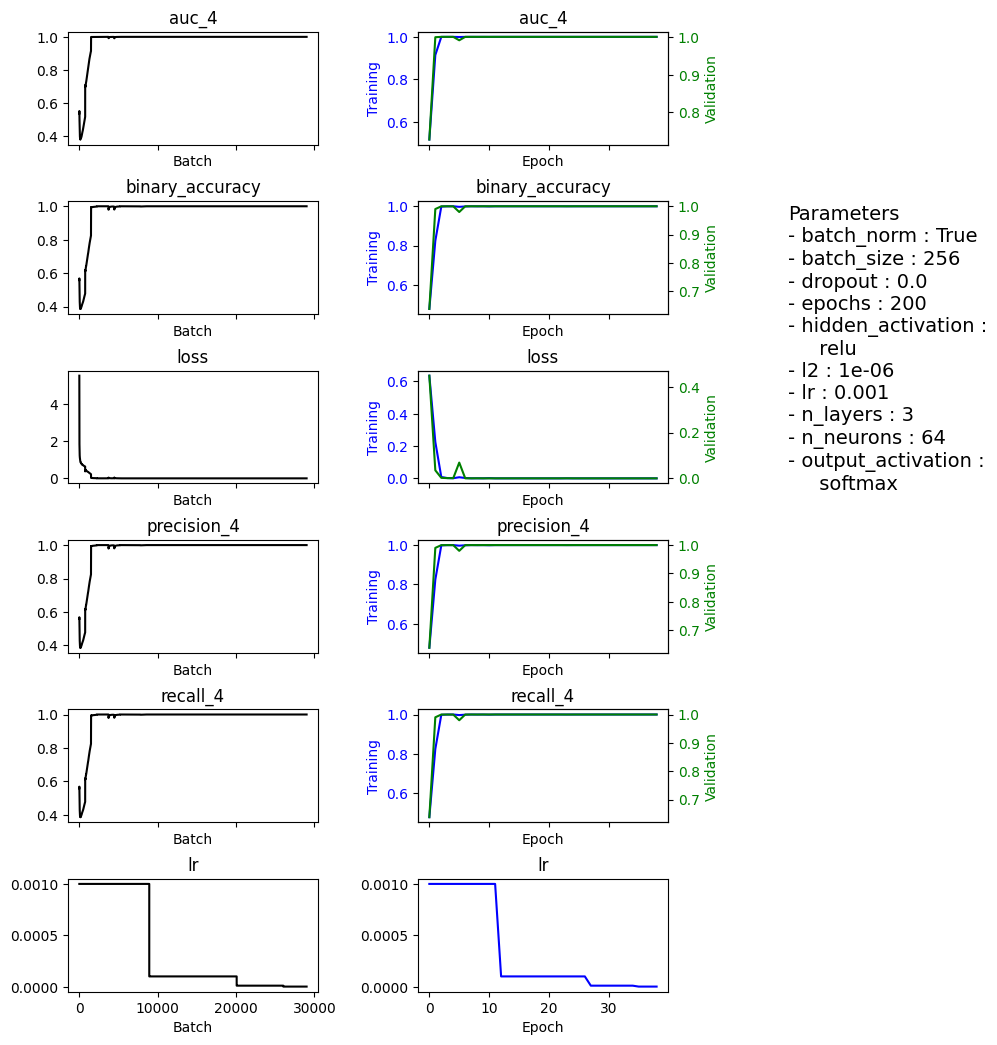

In [422]:
History.PlotHistory(loss_history,params=parameters,outputName=f'loss_{suffix}_{split}.png') # giving an error i.e.
# Params is a dict of parameters with name and values
# used for plotting
print("printed history")

In [429]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)

output_tags = [f'output {tag}' for tag in tags]
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
for output_tag in output_tags:
    if output_tag in test_df.columns:
        # If already output, need to remove to add again
        # avoid issues in case you run this cell multiple times
        del test_df[output_tag]

test_df = pd.concat((test_df,pd.DataFrame(output,columns=output_tags,index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

# Make the discriminator #
if 'd_HH' in test_df.columns:
    del test_df['d_HH']
    
signal_idx = [i for i,tag in enumerate(tags) if 'HH' in tag]

# d_HH = ln (P(HH) / (P(single H) + P(background)))

#test_df['d_HH'] = pd.Series(np.ones(test_df.shape[0]))

# Numerator #
num = pd.DataFrame((test_df[[output_tags[i] for i in range(len(tags)) if i in signal_idx]]).sum(axis=1))
# Denominator #
den = pd.DataFrame(test_df[[output_tags[i] for i in range(len(tags)) if i not in signal_idx]].sum(axis=1))
# Ln #
d_HH = np.log(num / den)
test_df['d_HH'] = d_HH

55/55 [==============================] - 0s 1ms/step


ROC curves
ROC curve of binary classification of HH node versus all the others


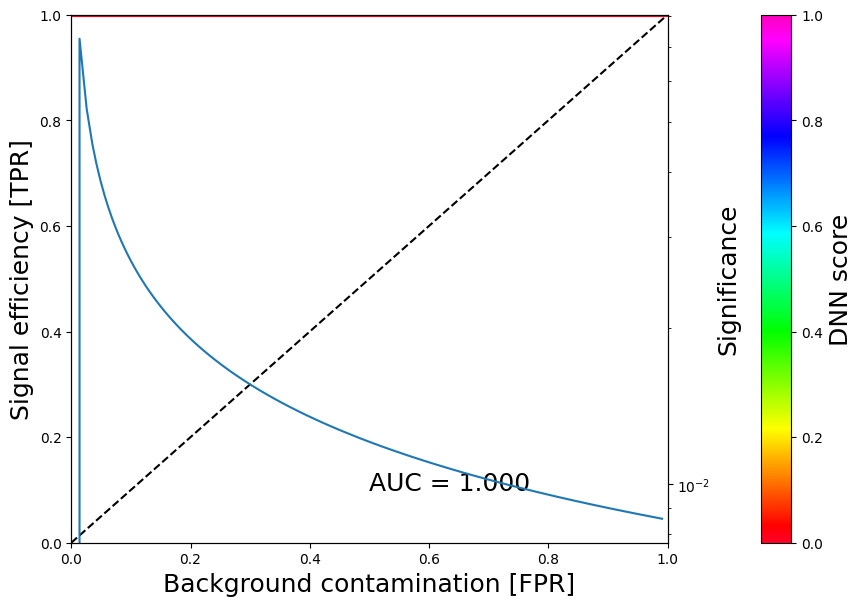

Saved ROC as roc_test1_odd_HH.pdf
Best WP based on significance = 0.00006
ROC curve of binary classification of background node versus all the others


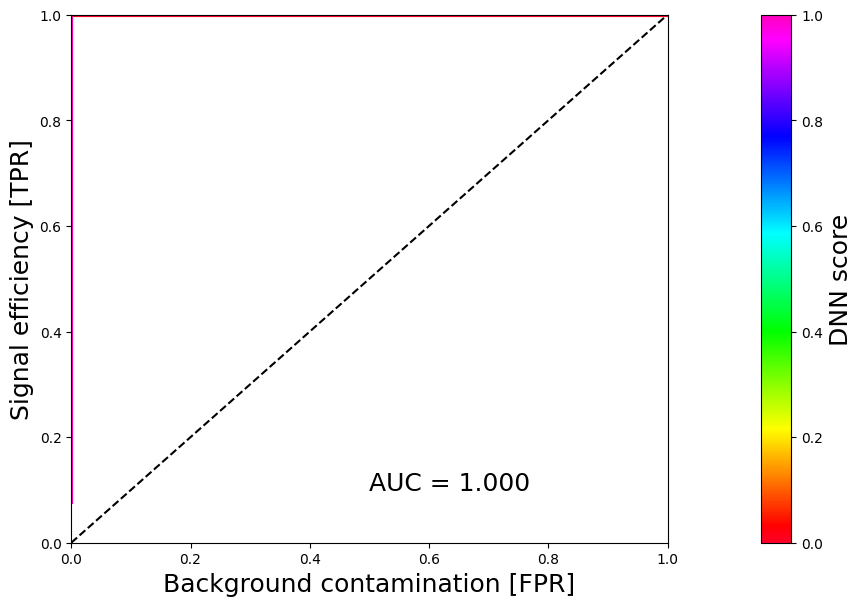

Saved ROC as roc_test1_odd_background.pdf
ROC curve of binary classification of d_HH


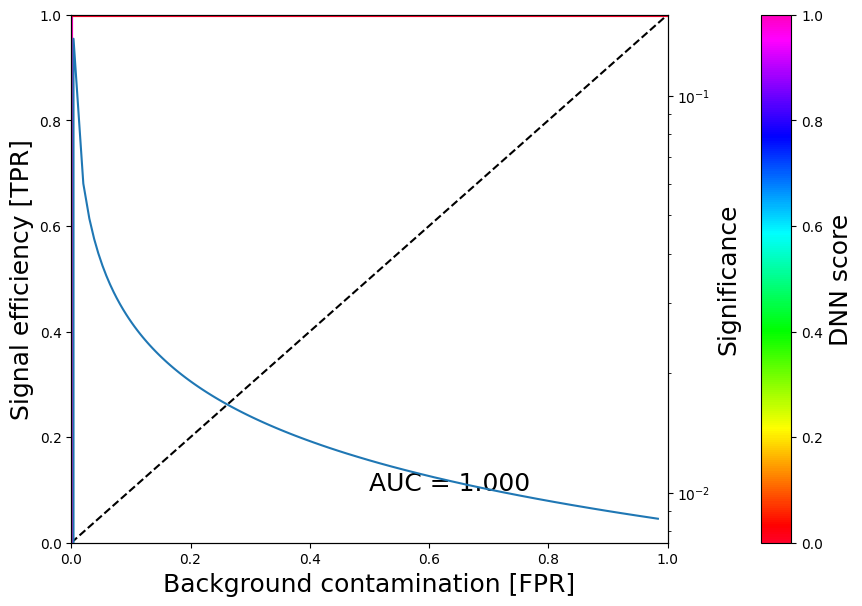

Saved ROC as roc_test1_odd_d_HH.pdf
Best WP based on significance = -8.98811
Multi roc curve for `output HH`


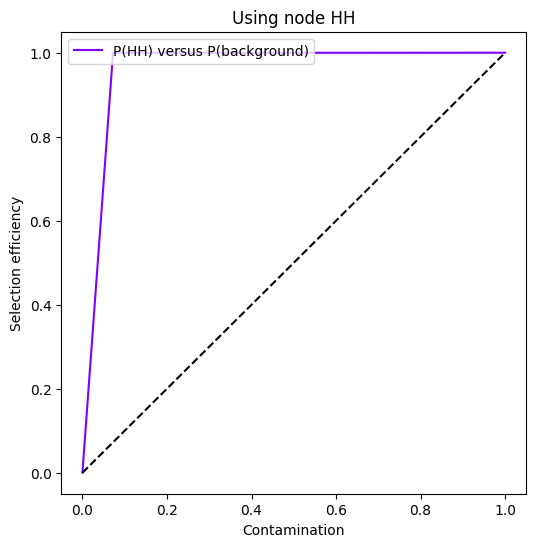

Saved multi ROC as multi_roc_test1_odd_output_HH.pdf
Multi roc curve for `output background`


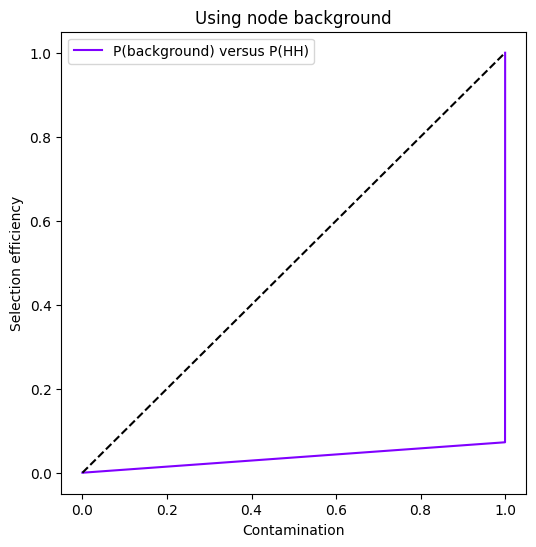

Saved multi ROC as multi_roc_test1_odd_output_background.pdf


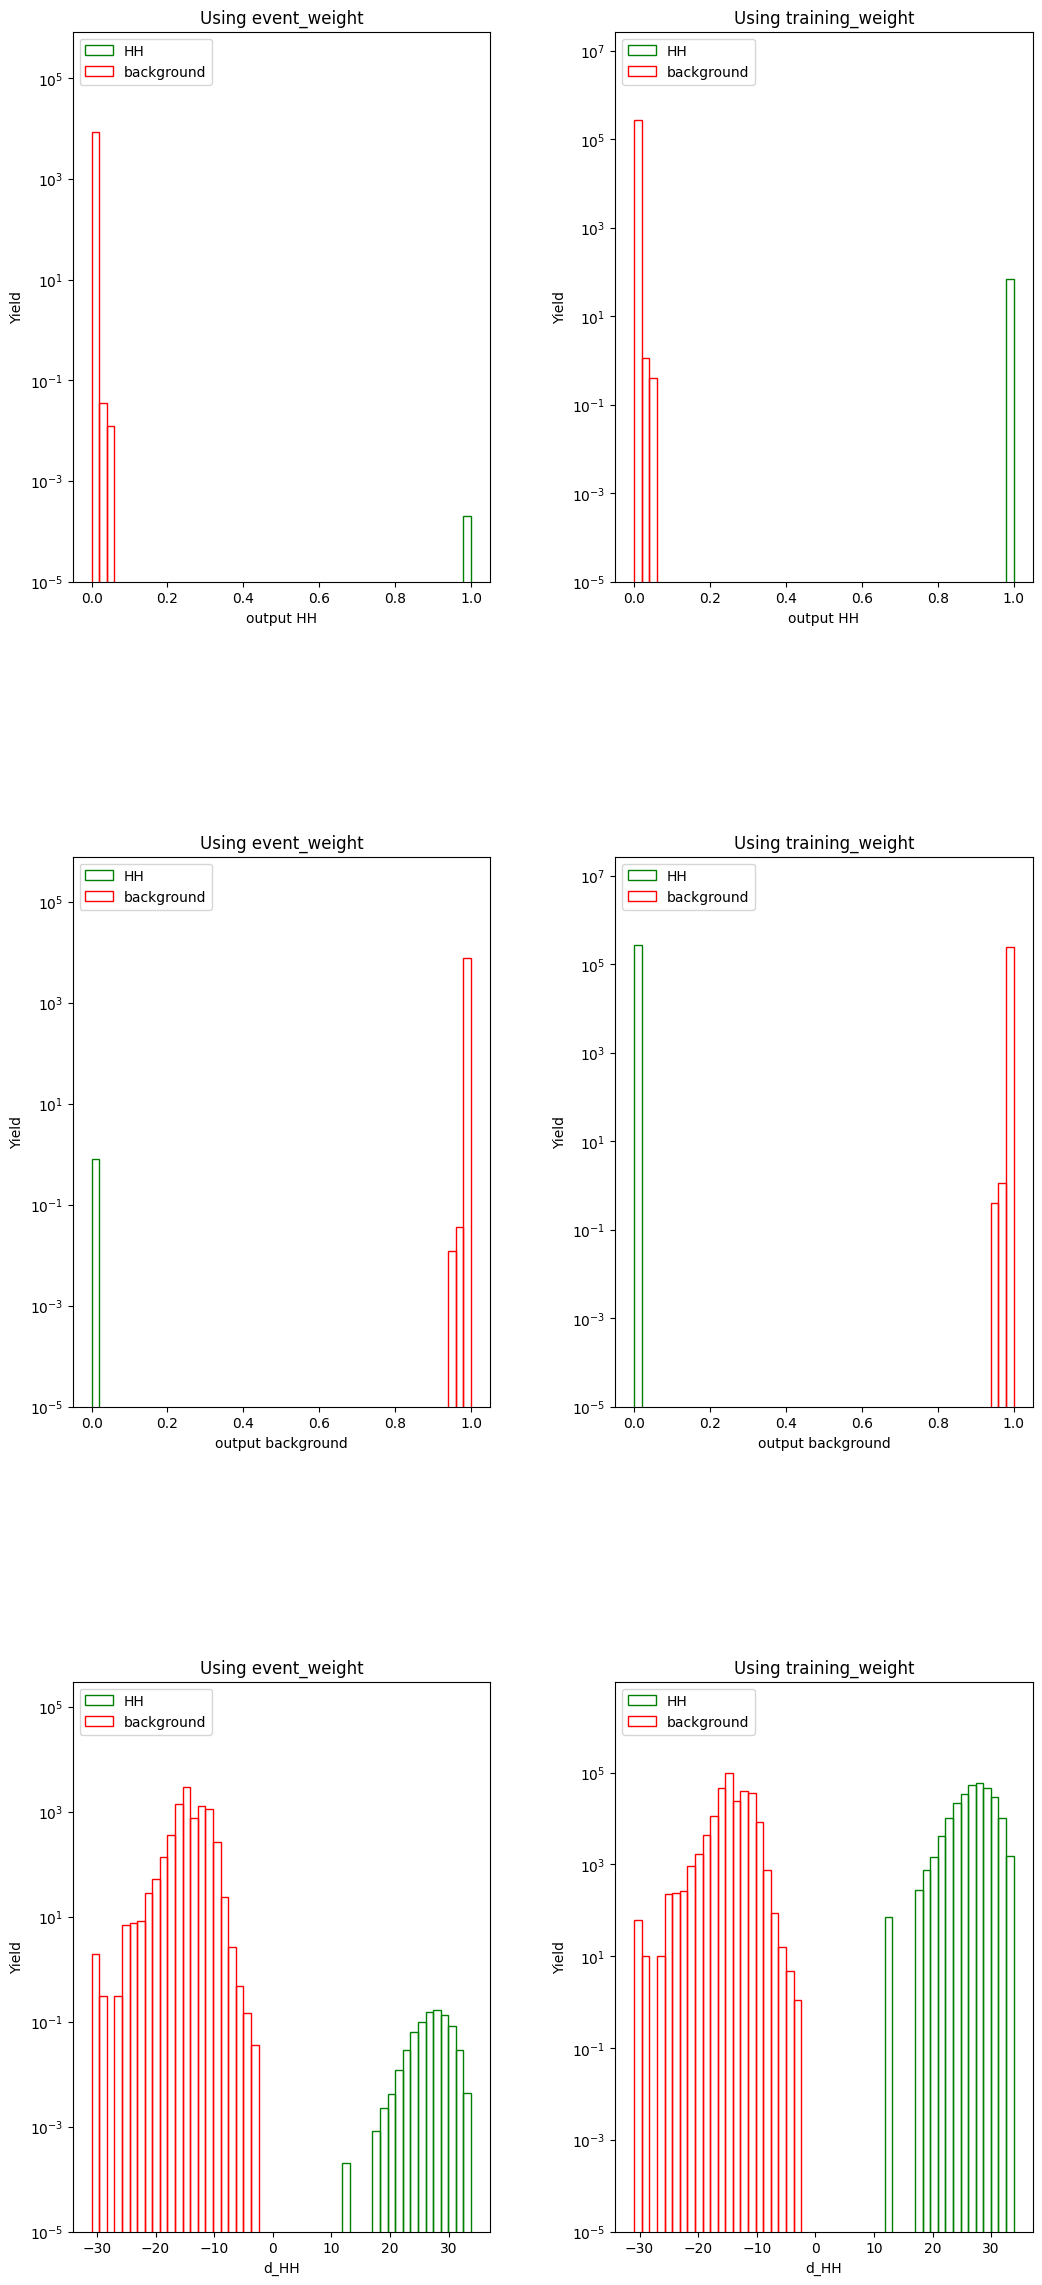

In [435]:
print("ROC curves")
import roc
importlib.reload(roc) # Reload in case file has changed
for tag in tags:
    print (f'ROC curve of binary classification of {tag} node versus all the others')
    roc.rocAndSig(y_true                 = test_df[tag],
                y_pred                 = test_df[f'output {tag}'],
                w_roc                  = test_df['training_weight'],
                w_sig                  = test_df['event_weight'],
                show_significance      = 'HH' in tag,
                outputName             = f'roc_{suffix}_{split}_{tag}.pdf')

# Multiclassification ROC curves are a bit harder to interpret than binary classification
# Here I do one versus the rest, so each ROC curves shows how the DNN is able to classify
# one class (HH, single H or background) versus all the others, which is one projection on
# how to see the performances
# For HH I show the significance but more as an information, because using only the HH node 
# means we do not use all the power of the multiclass (-> d_HH is for that)
print (f'ROC curve of binary classification of d_HH')
roc.rocAndSig(y_true                 = test_df['HH'],
            y_pred                 = test_df['d_HH'],
            w_roc                  = test_df['training_weight'],
            w_sig                  = test_df['event_weight'],
            show_significance      = True,
            outputName             = f'roc_{suffix}_{split}_d_HH.pdf')

# Tryign a new things, seeing the discrimination power of each node, class wise
for tag in tags:
    print (f'Multi roc curve for `output {tag}`')
    tags_order = [tag] + [t for t in tags if t != tag]
    roc.multiRoc(outputs    = [test_df[test_df['tag']==tag][f'output {tag}'] for tag in tags_order],
                tags       = tags_order,
                weights    = [test_df[test_df['tag']==tag]['training_weight'] for tag in tags_order],
                title      = f'Using node {tag}',
                outputName = f'multi_roc_{suffix}_{split}_output_{tag}.pdf')
    
fig,axs = plt.subplots(figsize=(12,25),nrows=len(tags)+1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.3,hspace=0.5)

tag_df = {tag:test_df[test_df['tag']==tag] for tag in tags}
colors = ['g','r','b']

# Manual binning so we can compute significance #
n_bins = 50

def get_bin_content(bins,y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for irow,output_tag in enumerate(output_tags+['d_HH']):
    for icol,weight in enumerate(['event_weight','training_weight']):
        # Fill the bins myself #
        bins = np.linspace(test_df[output_tag].min(),test_df[output_tag].max(),n_bins+1)
        centers = (bins[1:]+bins[:-1])/2
        widths = np.diff(bins)
        
        tag_content = {tag:get_bin_content(bins,tag_df[tag][output_tag],tag_df[tag][weight])for tag in tags}
        tag_cumsum_left = {tag:np.cumsum(tag_content[tag])/tag_content[tag].sum() for tag in tags}
        tag_cumsum_right = {tag:np.cumsum(tag_content[tag][::-1])[::-1]/tag_content[tag].sum() for tag in tags}
        # Need to integrate all the bins right of the DNN cut to get significance
        #z_left = np.nan_to_num(np.sqrt(2*((cumsum_s_left+cumsum_b_left)*np.log(1+cumsum_s_left/cumsum_b_left)-cumsum_s_left)))
        #z_right = np.nan_to_num(np.sqrt(2*((cumsum_s_right+cumsum_b_right)*np.log(1+cumsum_s_right/cumsum_b_right)-cumsum_s_right)))
        #z_left /= z_left.max()
        #z_right /= z_right.max()
        for i,(tag,content) in enumerate(tag_content.items()):
            axs[irow,icol].bar(x=centers,height=content,width=widths,fill=False,edgecolor=colors[i],label=tag)     
        #ax2=axs[irow,icol].twinx()   
        
        #ax2.plot(centers,z_left,color='r',label='Significance (left of cut) [normed]')
        #ax2.plot(centers,z_right,color='r',linestyle='--',label='Significance (right of cut) [normed]')

        #for i,tag in enumerate(tag_content.keys()):
        #    ax2.plot(centers,content,color=colors[i],linestyle='-',label=f'{tag} content (left of cut)')
        #    ax2.plot(centers,color=colors[i],linestyle='--',label=f'{tag} content (right of cut)')
        
        #ax2.set_yscale("log")
        #ax2.set_ylim([0,1.4])
        #ax2.set_ylabel('Cumulative distribution')
        #ax2.legend(loc='upper right')

        axs[irow,icol].set_title(f"Using {weight}")
        axs[irow,icol].set_xlabel(output_tag)
        axs[irow,icol].set_ylabel('Yield')
        axs[irow,icol].set_ylim(1e-5,max([content.max() for content in tag_content.values()])*100)
        axs[irow,icol].set_yscale('log')
        axs[irow,icol].legend(loc='upper left')
fig.savefig(f"prediction_{suffix}_{split}.pdf", dpi = 300)

In [437]:
# evaluate the model
print("evaluate the model...")
scores = model.evaluate(test_df[input_vars], 
                        test_df[tags], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


evaluate the model...
55/55 - 0s - loss: 1.1442e-04 - binary_accuracy: 1.0000 - auc_4: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - 100ms/epoch - 2ms/step
binary_accuracy: 100.00%


In [438]:
# save model and architecture to single file
modelName = f"model_{suffix}_{split}"
model.save(modelName)
print(f"Saved model to disk as {modelName}")

INFO:tensorflow:Assets written to: model_test1_odd/assets


INFO:tensorflow:Assets written to: model_test1_odd/assets


TypeError: Unable to serialize weight                   0.030939
ak4bjet1_pt             91.292542
ak4bjet1_eta            -0.000648
ak4bjet1_phi             0.000595
leadingLepton_pt        76.824974
leadingLepton_eta        0.002246
leadingLepton_phi        0.000975
subleadingLepton_pt     41.137810
subleadingLepton_eta    -0.002315
subleadingLepton_phi    -0.004908
dtype: float64 to JSON. Unrecognized type <class 'pandas.core.series.Series'>.